In [2]:
import time
import random
import numpy as np
import pandas as pd
import sys
import pickle
import h5py
import copy
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import torch
import learn2learn as l2l
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR
from functions.fftc import fft2c_new as fft2c
from functions.fftc import ifft2c_new as ifft2c
from functions.math import complex_abs, complex_mul, complex_conj
# The corase reconstruction is the rss of the zerofilled multi-coil kspaces
# after inverse FT.
from functions.data.transforms import UnetDataTransform_TTTpaper_fixMask, center_crop, scale_rss, normalize_separate_over_ch, rss_torch
# Import a torch.utils.data.Dataset class that takes a list of data examples, a path to those examples
# a data transform and outputs a torch dataset.
from functions.data.mri_dataset import SliceDataset
# Unet architecture as nn.Module
from functions.models.unet import Unet
# Function that returns a MaskFunc object either for generatig random or equispaced masks
from functions.data.subsample import create_mask_for_mask_type
# Implementation of SSIMLoss
from functions.training.losses import SSIMLoss
from functions.helper import evaluate2c_imagepair
### after you install bart 0.7.00 from https://mrirecon.github.io/bart/, import it as follows
sys.path.insert(0,'/cheng/bart-0.7.00/python/')
os.environ['TOOLBOX_PATH'] = "/cheng/bart-0.7.00/"
import bart


plt.rcParams.update({"text.usetex": True, "font.family": "serif", "font.serif": ["Computer Modern Roman"]})

colors = ['b','r','k','g','m','c','tab:brown','tab:orange','tab:pink','tab:gray','tab:olive','tab:purple']

markers = ["v","o","^","1","*",">","d","<","s","P","X"]
FONTSIZE = 22

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# seed
SEED = 1
random.seed(SEED)
np.random.seed(SEED)
torch.cuda.manual_seed(SEED)
torch.manual_seed(SEED)


### Load the data

In [3]:
# data path
path_test = '/cheng/metaMRI/metaMRI/data_dict/TTT_paper/TTT_brain_val.yaml'
path_test_sensmaps = '/cheng/metaMRI/metaMRI/data_dict/TTT_paper/sensmap_brain_val/'

# path_test = '/cheng/metaMRI/metaMRI/data_dict/TTT_paper/TTT_brain_test_100.yaml'
# path_test_sensmaps = '/cheng/metaMRI/metaMRI/data_dict/TTT_paper/sensmap_brain_test/'

# data transform
data_transform = UnetDataTransform_TTTpaper_fixMask('multicoil')

# training dataset and data loader
testset = SliceDataset(dataset = path_test, path_to_dataset='', 
                path_to_sensmaps = path_test_sensmaps, provide_senmaps=True, 
                challenge="multicoil", transform = data_transform, use_dataset_cache=True)

# shuffle = False !!!!!!!
test_dataloader = torch.utils.data.DataLoader(dataset = testset, batch_size = 1, 
                shuffle = False, generator = torch.Generator().manual_seed(1), pin_memory = False)


In [4]:
path_mask = '/cheng/metaMRI/ttt_for_deep_learning_cs/unet/test_data/anatomy_shift/mask2d'
with open(path_mask,'rb') as fn:
    mask2d = pickle.load(fn)
mask = torch.tensor(mask2d[0]).unsqueeze(0).unsqueeze(0).unsqueeze(-1)
mask = mask.to(device)

In [5]:
ssim_fct = SSIMLoss()
l1_loss = torch.nn.L1Loss(reduction='sum')
iterator = iter(test_dataloader)
batch = next(iterator)
origk, sens_maps, sens_maps_conj, binary_background_mask, fname, slice_num = batch
fname

('file_brain_AXT2_200_2000501',)

In [6]:
checkpoint_path = '/cheng/metaMRI/metaMRI/save/E12.1_joint(l1_1e-5)P_T300_300epoch/E_12.1_joint(l1_1e-5)P_T300_300epoch_E300_best.pth'
model = Unet(in_chans=2, out_chans=2, chans=64, num_pool_layers=4, drop_prob=0.0)
model.load_state_dict(torch.load(checkpoint_path))
model = model.to(device)

In [7]:
origk = origk.squeeze(0).to(device)
sens_maps = sens_maps.squeeze(0).to(device)
#sens_maps_conj = sens_maps_conj.squeeze(0).to(device)

# input k space
input_kspace = origk * mask + 0.0
# scale factor
scale_factor = scale_rss(input_kspace, model)
scale_input_kspace = scale_factor * input_kspace # [coils,height,width,2]

# gt image by normalized kspace: x
target_image_1c = rss_torch(complex_abs(ifft2c(origk))).unsqueeze(0)
# sensmap combine
# target_image = complex_mul(target_image, sens_maps_conj).sum(dim=0, keepdim=False)
crop_size = torch.Size([min(target_image_1c.shape[-2:]), min(target_image_1c.shape[-2:])])
crop_target_image = center_crop( target_image_1c, crop_size )
std_crop_target_image = crop_target_image.std()
mean_crop_target_image = crop_target_image.mean()

# A†y
# train_inputs = complex_mul(train_inputs, sens_maps_conj).sum(dim=0, keepdim=False) #shape: height,width,2
train_inputs = torch.moveaxis(rss_torch(ifft2c(scale_input_kspace)), -1, 0)   # [2, height, width]



###### training ######
# fθ(A†y)
model_output = model(train_inputs.unsqueeze(0))    # [1, 2, height, width]       
# S fθ(A†y) [coils, height, width, channel]
#output_sens_image = complex_mul(torch.moveaxis(model_output.unsqueeze(0), 1, -1 ), sens_maps)

output_sens_image = torch.zeros(sens_maps.shape).to(device) 
model_output = torch.moveaxis(model_output, 1, -1 )    #[1, height, width, 2]


In [8]:
model_output.shape

torch.Size([1, 768, 396, 2])

In [9]:
output_image_1c = complex_abs(model_output)

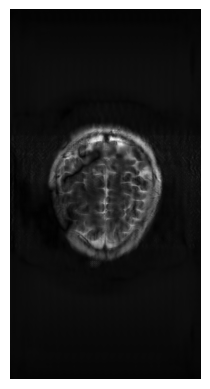

In [10]:
plt.imshow(output_image_1c.squeeze(0).cpu().detach().numpy(),cmap='gray')
plt.axis('off')
plt.show()

Masked output image

In [23]:
binary_mask_output_image_1c = (output_image_1c.unsqueeze(0) * binary_background_mask.to(device)).squeeze(0)

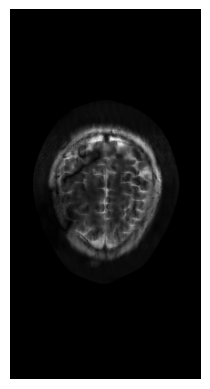

In [24]:
plt.imshow(binary_mask_output_image_1c.squeeze(0).cpu().detach().numpy(),cmap='gray')
plt.axis('off')
plt.show()

With background flipping

In [11]:
for j,s in enumerate(sens_maps):
    ss = s.clone()
    ss[torch.abs(ss)==0.0] = torch.abs(ss).max()
    output_sens_image[j,:,:,0] = model_output[0,:,:,0] * ss[:,:,0] - model_output[0,:,:,1] * ss[:,:,1]
    output_sens_image[j,:,:,1] = model_output[0,:,:,0] * ss[:,:,1] + model_output[0,:,:,1] * ss[:,:,0]
output_sens_image.shape

torch.Size([16, 768, 396, 2])

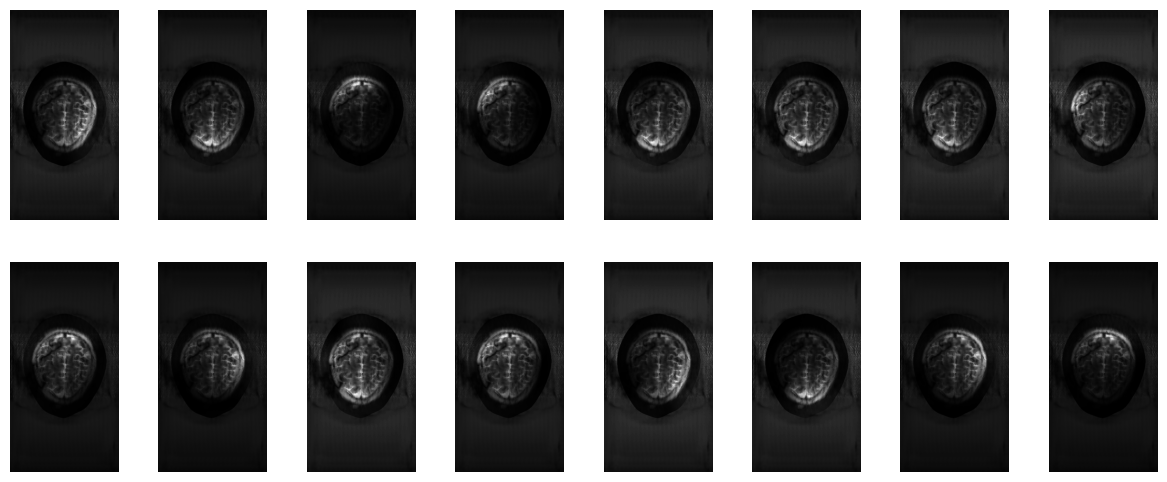

In [12]:
fig = plt.figure(figsize=(15,6))
for i, coil_image in enumerate(output_sens_image):
    ax = fig.add_subplot(2,8,i+1)
    ax.imshow(complex_abs(coil_image).cpu().detach().numpy(),'gray')
    ax.axis('off')

# plt.show()

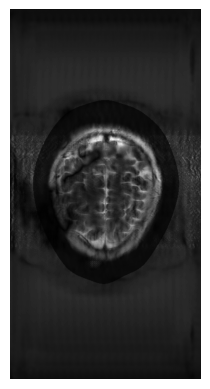

In [13]:
output_sens_image_1c = rss_torch(complex_abs(output_sens_image))
plt.imshow(output_sens_image_1c.squeeze(0).cpu().detach().numpy(),cmap='gray')
plt.axis('off')
plt.show()

Without background flipping

In [14]:
for j,s in enumerate(sens_maps):
    output_sens_image[j,:,:,0] = model_output[0,:,:,0] * s[:,:,0] - model_output[0,:,:,1] * s[:,:,1]
    output_sens_image[j,:,:,1] = model_output[0,:,:,0] * s[:,:,1] + model_output[0,:,:,1] * s[:,:,0]
output_sens_image.shape

torch.Size([16, 768, 396, 2])

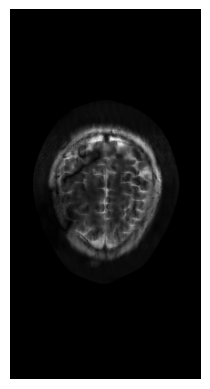

In [15]:
output_sens_image_1c = rss_torch(complex_abs(output_sens_image))
plt.imshow(output_sens_image_1c.squeeze(0).cpu().detach().numpy(),cmap='gray')
plt.axis('off')
plt.show()

Ground truth

In [16]:
complex_abs(ifft2c(origk)).shape

torch.Size([16, 768, 396])

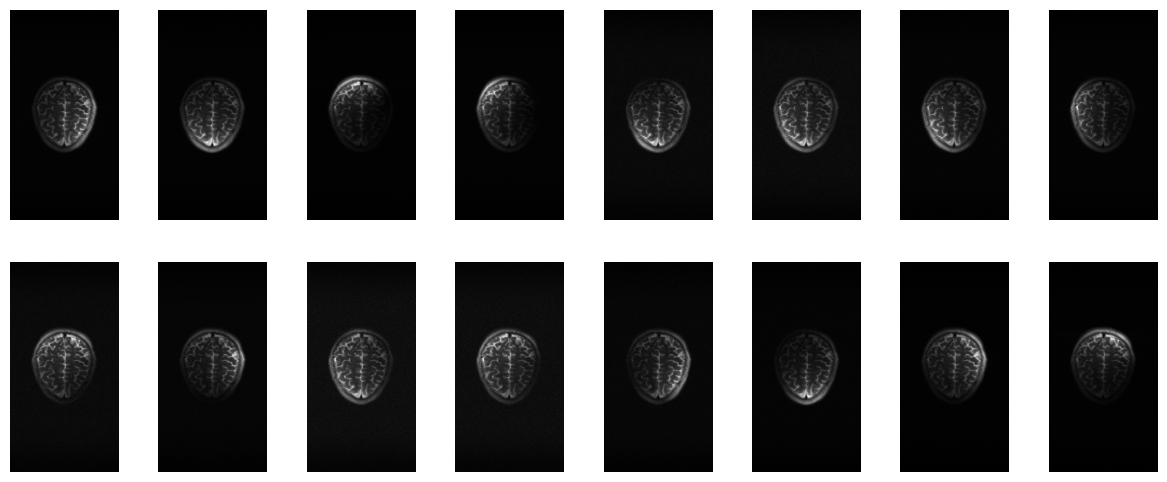

In [17]:
fig = plt.figure(figsize=(15,6))
for i, coil_image in enumerate(complex_abs(ifft2c(origk))):
    ax = fig.add_subplot(2,8,i+1)
    ax.imshow(coil_image.cpu().detach().numpy(),'gray')
    ax.axis('off')

# plt.show()

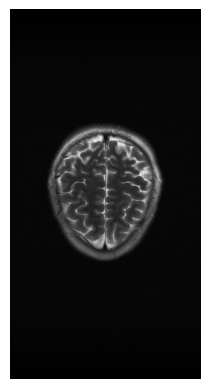

In [18]:
plt.imshow(target_image_1c.squeeze(0).cpu().detach().numpy(),cmap='gray')
plt.axis('off')
plt.show()